## Import Libraries

In [1]:
import pandas as pd
import nltk
from apyori import apriori


## Read dataset

In [2]:
df = pd.read_excel('twitter_fakenews_USElections_2016.xlsx')
df.columns

Index(['is_fake_news_1', 'is_fake_news_2', 'fake_news_category_1',
       'fake_news_category_2', 'tweet_id', 'created_at', 'retweet_count',
       'text', 'user_screen_name', 'user_verified', 'user_friends_count',
       'user_followers_count', 'user_favourites_count', 'tweet_source',
       'geo_coordinates_available', 'num_hashtags', 'num_mentions', 'num_urls',
       'num_media'],
      dtype='object')

## Pre processing

In [3]:
# Removing links
df['text'] = df['text'].replace(to_replace=r'http://\S+', value = '', regex=True)
df['text'] = df['text'].replace(to_replace=r'http\S+', value = '', regex=True)

In [4]:
# Removing punctuations
df['text'] = df['text'].replace(to_replace=r'(?<=\w)\.(?=\w)', value=' ', regex=True)
df['text'] = df['text'].replace(to_replace=r'[^\w\s]', value='', regex=True)

In [5]:
# Removing numbers
df['text'] = df['text'].replace(to_replace=r'\d+', value='', regex=True)


In [6]:
# Remove rows that start with "RT"
df = df[~df['text'].str.startswith('RT')]

In [7]:
# Removing extra spaces
df['text'] = df['text'].replace(to_replace=r'\s+', value=' ', regex=True)

In [8]:
# Tokenize the text
for i, row in df.iterrows():
    df.at[i, 'text'] = nltk.word_tokenize(df.at[i, 'text'])

In [9]:
# get list of stopwords in English
stopwords = nltk.corpus.stopwords.words("english")

# remove stopwords
for i, row in df.iterrows():
    df.at[i, 'text'] = [token.lower() for token in df.at[i, 'text'] if token.lower() not in stopwords]

In [10]:
df.shape

(8950, 19)

In [11]:
# Dropping all rows that has UNKNOWN in is_fake_news
df = df.drop(df[df['is_fake_news_1'] == 'UNKNOWN'].index)
df = df.drop(df[df['is_fake_news_2'] == 'UNKNOWN'].index)

In [12]:
df.shape

(8287, 19)

## Split the dataset into two based on is_fake_news_1

In [11]:
fake_news_data_1 = df[df['is_fake_news_1']==True]
real_news_data_1 = df[df['is_fake_news_1']==False]
fake_news_data_1 = fake_news_data_1.drop(columns=['is_fake_news_2', 'fake_news_category_2'])
real_news_data_1 = real_news_data_1.drop(columns=['is_fake_news_2', 'fake_news_category_2'])

In [12]:
print(fake_news_data_1.shape)
print(real_news_data_1.shape)


(397, 17)
(7890, 17)


## Split the dataset into two based on is_fake_news_2

In [13]:
fake_news_data_2 = df[df['is_fake_news_2']==True]
real_news_data_2 = df[df['is_fake_news_2']==False]
fake_news_data_2 = fake_news_data_2.drop(columns=['is_fake_news_1', 'fake_news_category_1'])
real_news_data_2 = real_news_data_2.drop(columns=['is_fake_news_1', 'fake_news_category_1'])

In [14]:
print(fake_news_data_2.shape)
print(real_news_data_2.shape)


(1646, 17)
(6641, 17)


## Association rule mining on real tweets

In [15]:
real_news_transactions = list(real_news_data_2['text'])
real_news_results = list(apriori(real_news_transactions,
        min_support=0.005,
        min_confidence=0.70,
        min_lift=1.0))

In [16]:
# Extract association rules from the results
real_association_rules = [rule for rule_set in real_news_results for rule in rule_set.ordered_statistics]

# Display association rules
for rule in real_association_rules:
    print("Rule:", rule.items_base, "=>", rule.items_add)
    # print("Support:", rule.support)
    print("Confidence:", rule.confidence)
    print("Lift:", rule.lift)
    print()

Rule: frozenset({'amazing'}) => frozenset({'realdonaldtrump'})
Confidence: 0.8125
Lift: 1.3160518292682926

Rule: frozenset({'call'}) => frozenset({'realdonaldtrump'})
Confidence: 0.8181818181818182
Lift: 1.3252549889135254

Rule: frozenset({'called'}) => frozenset({'realdonaldtrump'})
Confidence: 0.7924528301886793
Lift: 1.2835803037275655

Rule: frozenset({'congratulations'}) => frozenset({'realdonaldtrump'})
Confidence: 0.8205128205128206
Lift: 1.3290306441525954

Rule: frozenset({'donald'}) => frozenset({'trump'})
Confidence: 0.8258426966292135
Lift: 7.411380200425144

Rule: frozenset({'projects'}) => frozenset({'electionnight'})
Confidence: 0.88
Lift: 7.360302267002519

Rule: frozenset({'wins'}) => frozenset({'electionnight'})
Confidence: 0.703125
Lift: 5.880923331234257

Rule: frozenset({'fake'}) => frozenset({'realdonaldtrump'})
Confidence: 0.8222222222222223
Lift: 1.33179945799458

Rule: frozenset({'family'}) => frozenset({'realdonaldtrump'})
Confidence: 0.7037037037037037
Lift

In [17]:
len(real_association_rules)

129

In [18]:
for rule in real_association_rules:
    antecedent_items = set(rule.items_base)
    consequent_items = set(rule.items_add)
    if 'projects' in antecedent_items and 'fox' in consequent_items and 'news' in consequent_items:
        print("Rule:", rule.items_base, "=>", rule.items_add)
        print("Confidence:", rule.confidence)
        print("Lift:", rule.lift)
        print()

Rule: frozenset({'projects'}) => frozenset({'news', 'fox'})
Confidence: 0.7200000000000001
Lift: 97.58204081632654

Rule: frozenset({'projects'}) => frozenset({'electionnight', 'news', 'fox'})
Confidence: 0.7
Lift: 125.64054054054053

Rule: frozenset({'electionnight', 'projects'}) => frozenset({'news', 'fox'})
Confidence: 0.7954545454545454
Lift: 107.80844155844156



## Association rule mining on fake tweets

In [19]:
fake_news_transactions = list(fake_news_data_2['text'])
fake_news_results = list(apriori(fake_news_transactions,
        min_support=0.005,
        min_confidence=0.70,
        min_lift=1.0))

In [20]:
# Extract association rules from the results
fake_association_rules = [rule for rule_set in fake_news_results for rule in rule_set.ordered_statistics]

# Display association rules
for rule in fake_association_rules:
    print("Rule:", rule.items_base, "=>", rule.items_add)
    # print("Support:", rule.support)
    print("Confidence:", rule.confidence)
    print("Lift:", rule.lift)
    print()

Rule: frozenset({'orange'}) => frozenset({'black'})
Confidence: 0.7692307692307693
Lift: 43.6604774535809

Rule: frozenset({'day'}) => frozenset({'realdonaldtrump'})
Confidence: 0.7058823529411764
Lift: 2.204710347136957

Rule: frozenset({'de'}) => frozenset({'electionnight'})
Confidence: 0.9069767441860465
Lift: 2.8061724077635946

Rule: frozenset({'sexism'}) => frozenset({'didnt'})
Confidence: 0.7500000000000001
Lift: 44.08928571428572

Rule: frozenset({'donald'}) => frozenset({'trump'})
Confidence: 0.8593750000000001
Lift: 4.5048765923566885

Rule: frozenset({'el'}) => frozenset({'electionnight'})
Confidence: 0.9166666666666667
Lift: 2.8361528822055138

Rule: frozenset({'elections'}) => frozenset({'electionnight'})
Confidence: 0.9166666666666667
Lift: 2.8361528822055138

Rule: frozenset({'en'}) => frozenset({'electionnight'})
Confidence: 0.8400000000000001
Lift: 2.5989473684210527

Rule: frozenset({'everyone'}) => frozenset({'electionnight'})
Confidence: 0.7
Lift: 2.1657894736842103

In [21]:
len(fake_association_rules)

895

In [22]:
for rule in fake_association_rules:
    antecedent_items = set(rule.items_base)
    consequent_items = set(rule.items_add)
    if 'electionnight' in antecedent_items and 'win' in antecedent_items and 'hate' in antecedent_items and 'sexism' in consequent_items:
        print("Rule:", rule.items_base, "=>", rule.items_add)
        print("Confidence:", rule.confidence)
        print("Lift:", rule.lift)
        print()

Rule: frozenset({'hate', 'win', 'electionnight'}) => frozenset({'sexism'})
Confidence: 0.9
Lift: 123.45

Rule: frozenset({'hate', 'win', 'electionnight'}) => frozenset({'sexism', 'didnt'})
Confidence: 0.9
Lift: 164.6

Rule: frozenset({'electionnight', 'hate', 'win', 'didnt'}) => frozenset({'sexism'})
Confidence: 0.9
Lift: 123.45

Rule: frozenset({'hate', 'win', 'electionnight'}) => frozenset({'racism', 'sexism'})
Confidence: 0.9
Lift: 123.45

Rule: frozenset({'racism', 'hate', 'win', 'electionnight'}) => frozenset({'sexism'})
Confidence: 0.9
Lift: 123.45

Rule: frozenset({'hate', 'win', 'electionnight'}) => frozenset({'racism', 'sexism', 'didnt'})
Confidence: 0.9
Lift: 164.6

Rule: frozenset({'electionnight', 'hate', 'win', 'didnt'}) => frozenset({'racism', 'sexism'})
Confidence: 0.9
Lift: 123.45

Rule: frozenset({'racism', 'hate', 'win', 'electionnight'}) => frozenset({'sexism', 'didnt'})
Confidence: 0.9
Lift: 164.6

Rule: frozenset({'didnt', 'electionnight', 'win', 'racism', 'hate'})

In [23]:
fake_antecedent_items = []
for rule in fake_association_rules:
    fake_antecedent_items.append(set(rule.items_base))
unique_fake_antecedent_items = []
[unique_fake_antecedent_items.append(x) for x in fake_antecedent_items if x not in unique_fake_antecedent_items]
len(unique_fake_antecedent_items)

205

In [24]:
fake_consequent_items = []
for rule in fake_association_rules:
    fake_consequent_items.append(set(rule.items_add))
unique_fake_consequent_items = []
[unique_fake_consequent_items.append(x) for x in fake_consequent_items if x not in unique_fake_consequent_items]
len(unique_fake_consequent_items)

100

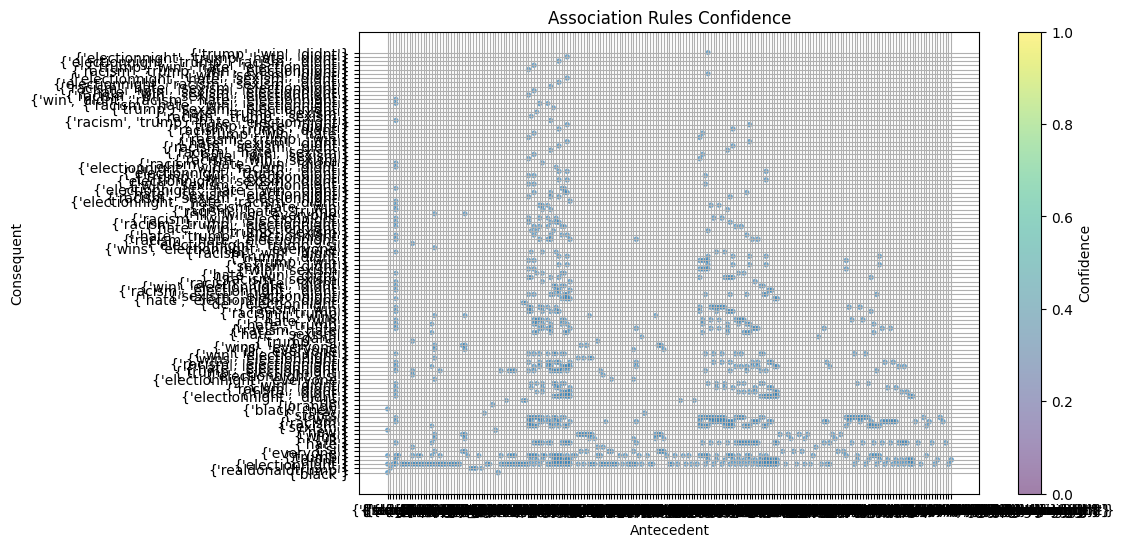

In [42]:
import matplotlib.pyplot as plt

# Create a dictionary to store confidence values for each (x, y) combination
confidence_dict = {}

# Populate the confidence dictionary
for rule in fake_association_rules:
    x = frozenset(list(rule.items_base))  # Convert set to frozen set
    y = frozenset(list(rule.items_add))   # Convert set to frozen set
    confidence = rule.confidence
    confidence_dict[(frozenset(x), frozenset(y))] = confidence

# Create lists to store x, y, and size values for plotting
x_values = []
y_values = []
sizes = []

# Iterate through unique combinations and append values to the lists
for x in unique_fake_antecedent_items:
    for y in unique_fake_consequent_items:
        x_frozen = frozenset(x)
        y_frozen = frozenset(y)
        if (x_frozen, y_frozen) in confidence_dict:
            x_values.append(unique_fake_antecedent_items.index(x))
            y_values.append(unique_fake_consequent_items.index(y))
            sizes.append(confidence_dict[(x_frozen, y_frozen)]*10)
        # else:
            # If no association rule exists, set dot size to 0
            # sizes.append(0)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, s=sizes, alpha=0.5)

# Set labels for x and y axes
plt.xticks(range(len(unique_fake_antecedent_items)), unique_fake_antecedent_items)
plt.yticks(range(len(unique_fake_consequent_items)), unique_fake_consequent_items)
plt.xlabel('Antecedent')
plt.ylabel('Consequent')

# Set title for the plot
plt.title('Association Rules Confidence')

# Show the plot
plt.colorbar(label='Confidence')
plt.grid(True)
plt.show()

{(frozenset({'sexism'}), frozenset({'didnt'})): 0.7500000000000001, (frozenset({'sexism'}), frozenset({'electionnight'})): 0.9166666666666667, (frozenset({'sexism'}), frozenset({'hate'})): 1.0, (frozenset({'sexism'}), frozenset({'racism'})): 1.0, (frozenset({'sexism'}), frozenset({'trump'})): 0.9166666666666667, (frozenset({'sexism'}), frozenset({'win'})): 0.7500000000000001, (frozenset({'hate', 'didnt'}), frozenset({'electionnight'})): 1.0, (frozenset({'hate', 'electionnight'}), frozenset({'didnt'})): 0.7142857142857143, (frozenset({'racism', 'didnt'}), frozenset({'electionnight'})): 1.0, (frozenset({'racism', 'electionnight'}), frozenset({'didnt'})): 0.7142857142857143, (frozenset({'sexism'}), frozenset({'electionnight', 'didnt'})): 0.7500000000000001, (frozenset({'sexism', 'didnt'}), frozenset({'electionnight'})): 1.0, (frozenset({'sexism', 'electionnight'}), frozenset({'didnt'})): 0.8181818181818182, (frozenset({'trump', 'didnt'}), frozenset({'electionnight'})): 1.0, (frozenset({'w

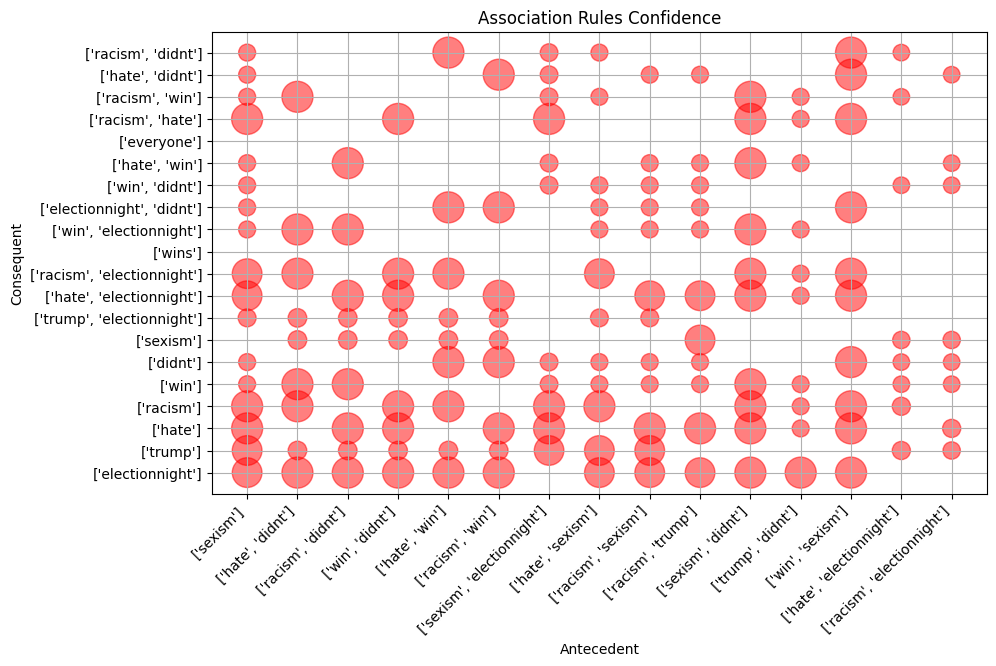

In [63]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the number of association rules associated with each unique x point
x_counts = Counter()
for rule in fake_association_rules:
    x = frozenset(list(rule.items_base))
    x_counts[x] += 1

# Count the number of association rules associated with each unique y point
y_counts = Counter()
for rule in fake_association_rules:
    y = frozenset(list(rule.items_add))
    y_counts[y] += 1

# Select the top 15 x points and top 20 y points based on counts
top_x_points = [x for x, _ in x_counts.most_common(15)]
top_y_points = [y for y, _ in y_counts.most_common(20)]
# Create a dictionary to store confidence values for each (x, y) combination
confidence_dict = {}

# Populate the confidence dictionary
for rule in fake_association_rules:
    x = frozenset(list(rule.items_base))  # Convert set to frozen set
    y = frozenset(list(rule.items_add))   # Convert set to frozen set
    confidence = rule.confidence
    if x in top_x_points and y in top_y_points:
        confidence_dict[(x, y)] = confidence

# Create lists to store x, y, and size values for plotting
x_values = []
y_values = []
sizes = []

# Iterate through top x and y points and append values to the lists
for x in top_x_points:
    for y in top_y_points:
        if (x, y) in confidence_dict:
            x_values.append(top_x_points.index(x))
            y_values.append(top_y_points.index(y))
            if confidence_dict[(x, y)] > 0.9:
                sizes.append(confidence_dict[(x, y)]*500)
            else:
                sizes.append(confidence_dict[(x, y)]*200)

print(confidence_dict)
# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.grid(True)

plt.scatter(x_values, y_values, s=sizes, alpha=0.5, c='red')

# Set labels for x and y axes
plt.xticks(range(len(top_x_points)), [list(x) for x in top_x_points], rotation=45, ha='right')
plt.yticks(range(len(top_y_points)), [list(y) for y in top_y_points])
plt.xlabel('Antecedent')
plt.ylabel('Consequent')

# Set title for the plot
plt.title('Association Rules Confidence')

# Show the plot
plt.show()
